In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [2]:
s = 0.001
c = 0.25

In [3]:
import arm
arm.init(f'data/rust_vectors_product_category_no_fuel.pkl', pickled=True)

In [4]:
%time arm_bi = arm.generate_bicluster_rules(min_support=s, min_confidence=c)

CPU times: user 47 s, sys: 2.93 s, total: 49.9 s
Wall time: 50.9 s


In [5]:
%time arm_intra = arm.generate_intracluster_rules(min_support=s, min_confidence=c)

CPU times: user 9.94 s, sys: 871 ms, total: 10.8 s
Wall time: 11.2 s


In [6]:
from apriori import get_apriori_rules
%time apri_rules = get_apriori_rules(s, c)

Finished in 1.45 minutes.
CPU times: user 1min 25s, sys: 498 ms, total: 1min 26s
Wall time: 1min 27s


In [7]:
print(f'   MST (bi-cluster): {len(arm_bi):,}\nMST (intra-cluster): {len(arm_intra):,}\n            Apriori: {len(apri_rules):,}')

   MST (bi-cluster): 123
MST (intra-cluster): 60
            Apriori: 1,222


In [8]:
key = lambda rule: rule.support
arm_bi.sort(key=key, reverse=True)
arm_intra.sort(key=key, reverse=True)
apri_rules.sort(key=key, reverse=True)

In [9]:
arm_rules = []
for r in arm_bi:
    arm_rules.append(['bi-cluster', r])
for r in arm_intra:
    arm_rules.append(['intra-cluster', r])

arm_rules.sort(key=lambda x: x[1].support, reverse=True)
len(arm_rules)

183

In [15]:
def is_equal(mst, apri, is_combined=False):
    return (mst.lhs == apri.lhs) and (mst.rhs == apri.rhs)

In [16]:
def match(mst, apri, is_combined=False):
    count = 0
    for a in apri:
        for m in mst:
            mr = m[1] if is_combined else m
            if is_equal(mr, a, is_combined):
                count += 1
                break
    return count/len(mst) * 100

In [17]:
intra_match = match(arm_intra, apri_rules)
print(f'{intra_match:.2f}%')

53.33%


In [18]:
bi_match = match(arm_bi, apri_rules)
print(f'{bi_match:.2f}%')

61.79%


In [19]:
full_match = match(arm_rules, apri_rules, is_combined=True)
print(f'{full_match:.2f}%')

59.02%


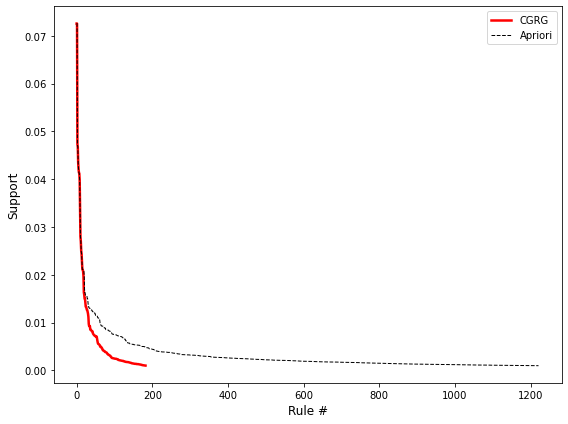

In [23]:
mst_data = [r[1].support for r in arm_rules]
apri_data = [r.support for r in apri_rules]
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(mst_data, '-', color='r', linewidth=2.5, label='CGRG')
plt.plot(apri_data, '--', color='k', linewidth=1, label='Apriori')

plt.legend()
plt.ylabel('Support', fontsize=12)
plt.xlabel('Rule #', fontsize=12)
plt.tight_layout()
plt.savefig('../images/ruleset_support.png', dpi=500)
plt.show()

In [24]:
temp_mst = arm_rules.copy()
temp_apri = apri_rules.copy()

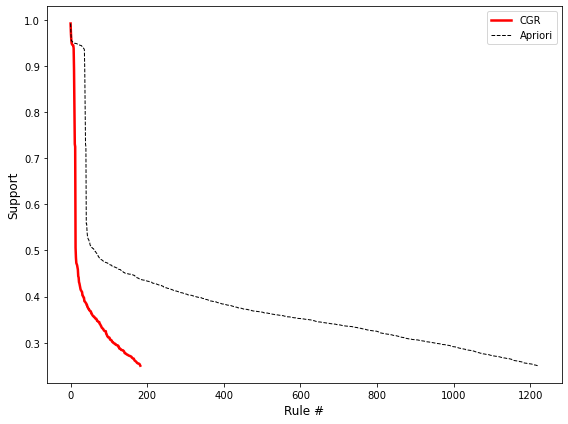

In [25]:
temp_mst.sort(key = lambda x: x[1].confidence, reverse=True)
temp_apri.sort(key = lambda x: x.confidence, reverse=True)
mst_data = [r[1].confidence for r in temp_mst]
apri_data = [r.confidence for r in temp_apri]
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(mst_data, '-', color='r', linewidth=2.5, label='CGR')
plt.plot(apri_data, '--', color='k', linewidth=1, label='Apriori')

plt.legend()
plt.ylabel('Support', fontsize=12)
plt.xlabel('Rule #', fontsize=12)
plt.tight_layout()
plt.savefig('../images/ruleset_confidence.png', dpi=500)
plt.show()

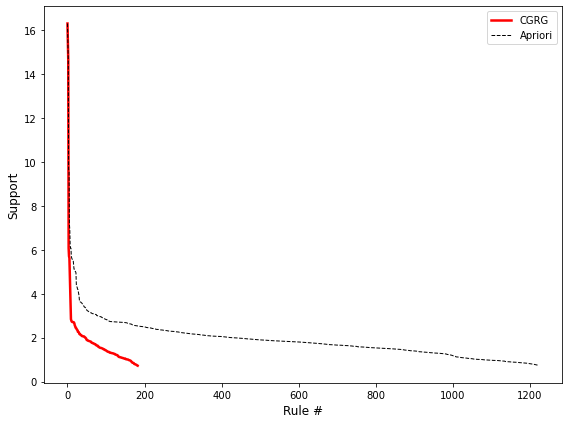

In [26]:
temp_mst.sort(key = lambda x: x[1].lift, reverse=True)
temp_apri.sort(key = lambda x: x.lift, reverse=True)
mst_data = [r[1].lift for r in temp_mst]
apri_data = [r.lift for r in temp_apri]
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(mst_data, '-', color='r', linewidth=2.5, label='CGRG')
plt.plot(apri_data, '--', color='k', linewidth=1, label='Apriori')

plt.legend()
plt.ylabel('Support', fontsize=12)
plt.xlabel('Rule #', fontsize=12)
plt.tight_layout()
plt.savefig('../images/ruleset_lift.png', dpi=500)
plt.show()

In [27]:
def rule_print(r, is_combined=False):
    suffix = ''
    if is_combined:
        suffix = r[0]
        r = r[1]
    
    lhs = '\\texttt{\\{' + ','.join(r.lhs) + '\\}'
    rhs = '\\{' + ','.join(r.rhs) + '\\}}'
    stats = f'support: {r.support:.4f} | confidence: {r.confidence:.4f} | lift: {r.lift:.4f}'
    if is_combined:
        stats += f' | type: {suffix}'
    stats = '\\texttt{' + stats + '}'
    print(f'{lhs} $\\rightarrow$ {rhs}\\\\{stats}\\\\')

In [52]:
def rule_table(rules, is_combined=False):
    cols = ['Antecedent', 'Consequent', 'Support', 'Confidence', 'Lift', 'Type']
    ls = 'l' * len(cols)
    preamble = "\\begin{longtable}\n{@{}" + ls + "@{}}\\toprule " + "& ".join(cols) + "\\\\*\\midrule\\endfirsthead\\endhead\n"

    for r in rules:
        type_rule = 'Apriori'
        if is_combined:
            type_rule = r[0]
            r = r[1]
        lhs = '\\{' + ','.join(r.lhs) + '\\}'
        rhs = '\\{' + ','.join(r.rhs) + '\\}'
        row = f'{lhs} & {rhs} & {r.support:.4f} & {r.confidence:.4f} & {r.lift:.4f} & {type_rule}\\\\\n'
        preamble += row
    
    preamble += "\\midrule\\end{longtable}"
    print(preamble)

In [53]:
rule_table(apri_rules[:5])

\begin{longtable}
{@{}llllll@{}}\toprule Antecedent& Consequent& Support& Confidence& Lift& Type\\*\midrule\endfirsthead\endhead
\{chewing gum and candy\} & \{cigarettes\} & 0.0726 & 0.2986 & 1.0985 & Apriori\\
\{cigarettes\} & \{chewing gum and candy\} & 0.0726 & 0.2671 & 1.0985 & Apriori\\
\{water\} & \{chewing gum and candy\} & 0.0473 & 0.3052 & 1.2554 & Apriori\\
\{filters\} & \{lubricant\} & 0.0468 & 0.9381 & 2.6850 & Apriori\\
\{chocolates\} & \{chewing gum and candy\} & 0.0435 & 0.3117 & 1.2820 & Apriori\\
\midrule\end{longtable}


In [55]:
rule_table(arm_rules[:5], is_combined=True)

\begin{longtable}
{@{}llllll@{}}\toprule Antecedent& Consequent& Support& Confidence& Lift& Type\\*\midrule\endfirsthead\endhead
\{chewing gum and candy\} & \{cigarettes\} & 0.0726 & 0.2986 & 1.0985 & bi-cluster\\
\{cigarettes\} & \{chewing gum and candy\} & 0.0726 & 0.2671 & 1.0985 & bi-cluster\\
\{water\} & \{chewing gum and candy\} & 0.0473 & 0.3052 & 1.2554 & intra-cluster\\
\{filters\} & \{lubricant\} & 0.0468 & 0.9381 & 2.6850 & intra-cluster\\
\{chocolates\} & \{chewing gum and candy\} & 0.0435 & 0.3117 & 1.2820 & bi-cluster\\
\midrule\end{longtable}


In [28]:
for r in apri_rules[:5]:
    rule_print(r)

\texttt{\{chewing gum and candy\} $\rightarrow$ \{cigarettes\}}\\\texttt{support: 0.0726 | confidence: 0.2986 | lift: 1.0985}\\
\texttt{\{cigarettes\} $\rightarrow$ \{chewing gum and candy\}}\\\texttt{support: 0.0726 | confidence: 0.2671 | lift: 1.0985}\\
\texttt{\{water\} $\rightarrow$ \{chewing gum and candy\}}\\\texttt{support: 0.0473 | confidence: 0.3052 | lift: 1.2554}\\
\texttt{\{filters\} $\rightarrow$ \{lubricant\}}\\\texttt{support: 0.0468 | confidence: 0.9381 | lift: 2.6850}\\
\texttt{\{chocolates\} $\rightarrow$ \{chewing gum and candy\}}\\\texttt{support: 0.0435 | confidence: 0.3117 | lift: 1.2820}\\


In [29]:
for r in arm_rules[:5]:
    rule_print(r, is_combined=True)

\texttt{\{chewing gum and candy\} $\rightarrow$ \{cigarettes\}}\\\texttt{support: 0.0726 | confidence: 0.2986 | lift: 1.0985 | type: bi-cluster}\\
\texttt{\{cigarettes\} $\rightarrow$ \{chewing gum and candy\}}\\\texttt{support: 0.0726 | confidence: 0.2671 | lift: 1.0985 | type: bi-cluster}\\
\texttt{\{water\} $\rightarrow$ \{chewing gum and candy\}}\\\texttt{support: 0.0473 | confidence: 0.3052 | lift: 1.2554 | type: intra-cluster}\\
\texttt{\{filters\} $\rightarrow$ \{lubricant\}}\\\texttt{support: 0.0468 | confidence: 0.9381 | lift: 2.6850 | type: intra-cluster}\\
\texttt{\{chocolates\} $\rightarrow$ \{chewing gum and candy\}}\\\texttt{support: 0.0435 | confidence: 0.3117 | lift: 1.2820 | type: bi-cluster}\\
